## Universidade Estadual de Campinas 
## Instituto de Computação
# Imparcialidade
## MO810/MC959 - Tópicos em Inteligência Artificial
## Ética em Aprendizado de Máquina
### Prof. Marcos M. Raimundo
---
### Alunos:
#### Mateus Trentini RA 217290
#### Mauricio Pereira Lopes RA 225242
#### Rita Braga RA 251627
---

In [3]:
# load required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.datasets import StandardDataset
from aif360 import sklearn

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [2]:
# load datasets

df_train = pd.read_excel("../data/processed/train_data.xlsx")
df_val = pd.read_excel("../data/processed/validation_data.xlsx")
df_test = pd.read_excel("../data/processed/test_data.xlsx")
df_train.head()

,Unnamed: 0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,27623,27623,50000,2,1,2,23,-1,-1,-1,...,4800,9810,660,2548,2321,4800,9810,660,2980,0
1,28377,28377,50000,2,2,1,36,2,2,2,...,47956,43578,35126,0,4700,0,2004,3500,0,0
2,10918,10918,200000,2,3,1,54,6,5,4,...,102549,101400,0,0,0,0,0,0,0,0
3,27235,27235,240000,1,1,1,35,-1,-1,-1,...,17102,13367,22659,2017,21817,1120,13434,22772,22820,0
4,15172,15172,60000,2,1,2,23,0,0,0,...,8549,7635,12258,3126,1392,5033,3601,5200,3647,0


---
# Enuncie e apresente uma ou mais métricas de imparcialidade mais ajustadas à aplicação escolhida, justifique.

---
## Measuring Fairness Using Equal Opportunity

In [4]:
# load trained model
rf_model = pickle.load(open('../models/best_rf.pkl', 'rb'))

In [5]:
# predict on validation dataset
X_val = df_val.drop(columns=['Unnamed: 0', 'ID', 'default payment next month'])
# Random Forest model's prediction
y_hat_rf = rf_model.predict(X_val)

In [6]:
def equal_opp(df_val, y_pred, y_val, priv_class, unpriv_class, sensitive_attribute_name):
    
    # create new datafrane with sensitive attributes, predictions for each model and ground truth
    y_hat_vs_y_val = pd.DataFrame({sensitive_attribute_name: df_val[sensitive_attribute_name],
                                   'y_hat_rf': y_pred, 
                                   'y_val': y_val})
    
    # Separate data by sex
    privileged = y_hat_vs_y_val[y_hat_vs_y_val[sensitive_attribute_name] == priv_class]
    unprivileged = y_hat_vs_y_val[y_hat_vs_y_val[sensitive_attribute_name] == unpriv_class]
    
    # Calculate confusion matrices for each group
    privileged_matrix = confusion_matrix(privileged.y_hat_rf, privileged.y_val)
    unprivileged_matrix = confusion_matrix(unprivileged.y_hat_rf, unprivileged.y_val)
    
    # Calculate true positive rates for each group
    privileged_tpr = privileged_matrix[1,1] / (privileged_matrix[1,0] + privileged_matrix[1,1])
    unprivileged_tpr = unprivileged_matrix[1,1] / (unprivileged_matrix[1,0] + unprivileged_matrix[1,1])
    equal_opp_metric = privileged_tpr - unprivileged_tpr

    return privileged_tpr, unprivileged_tpr, equal_opp_metric

In [7]:
male_tpr, female_tpr, equal_opp_metric = equal_opp(df_val,
                                                   y_hat_rf,
                                                   df_val['default payment next month'],
                                                   1,
                                                   2,
                                                   'SEX')

In [8]:
# Compare true positive rates to assess fairness
if equal_opp_metric:
    print("Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).")
else:
    print("Random Forest model: The algorithm does not have Equal Opportunity for both groups (male vs female).")

# Output true positive rates
print("\nTrue Positive Rates:")
print("Male: {:.3f}".format(male_tpr))
print("Female: {:.3f}".format(female_tpr))
print('Equal Opportunity Metric: {:.3f}'.format(equal_opp_metric))

Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).

True Positive Rates:
Male: 0.621
Female: 0.667
Equal Opportunity Metric: -0.046


---
## Disparate impact

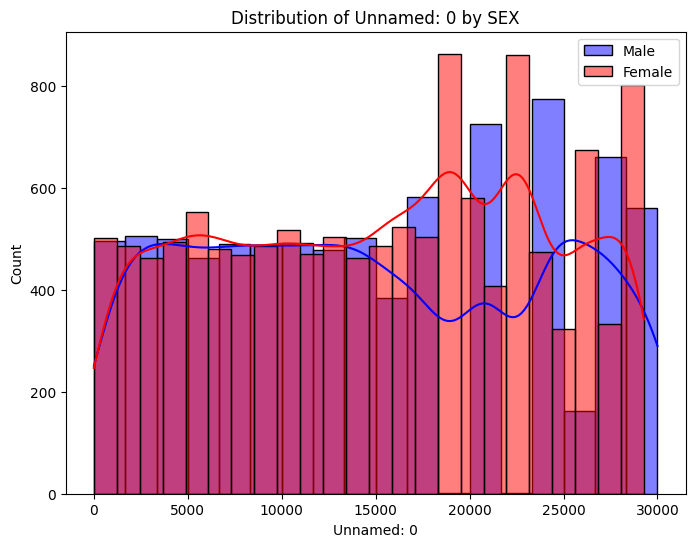

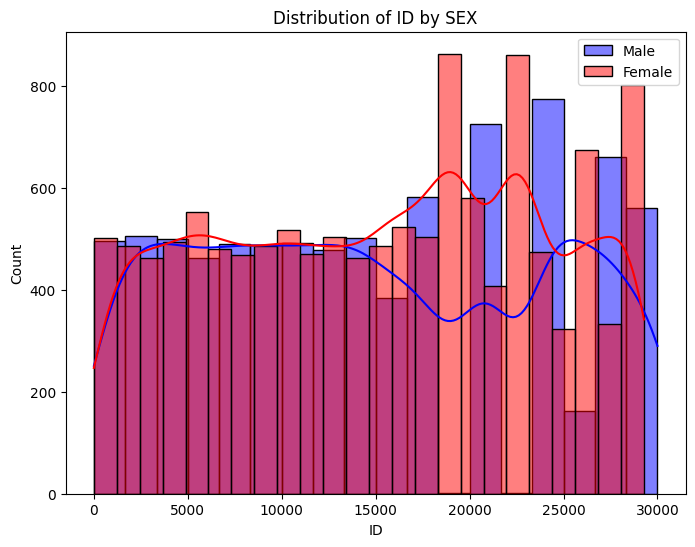

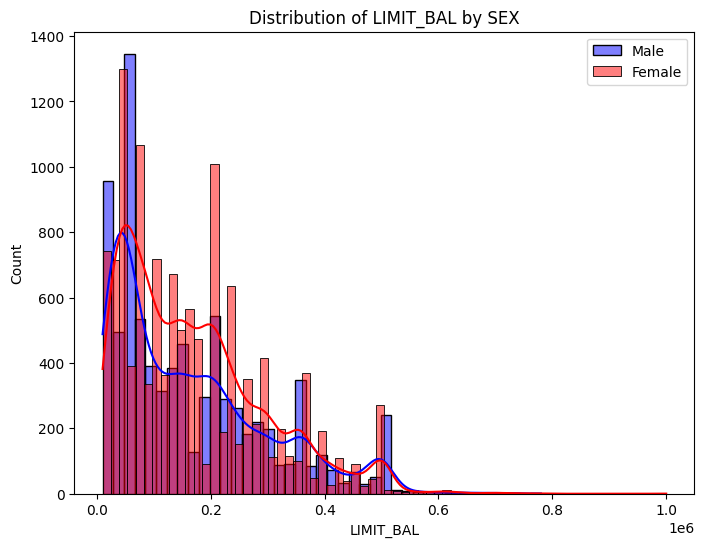

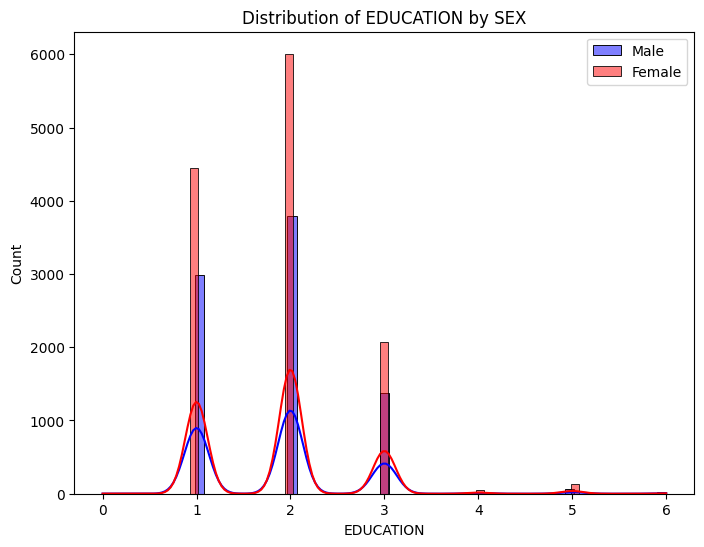

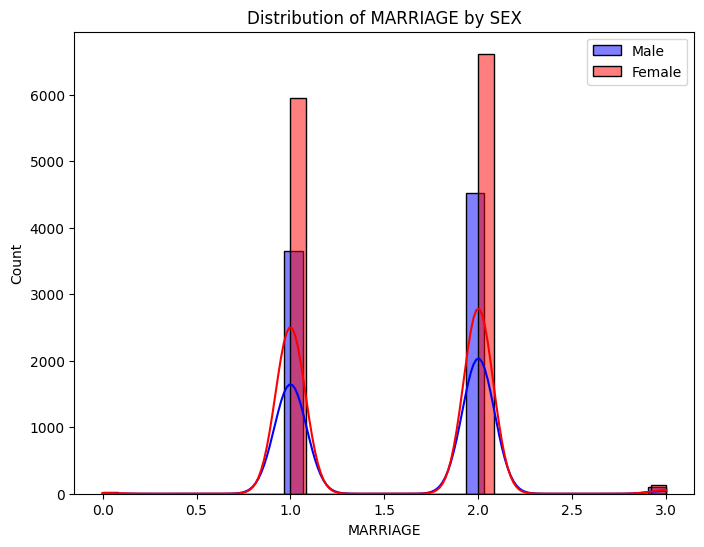

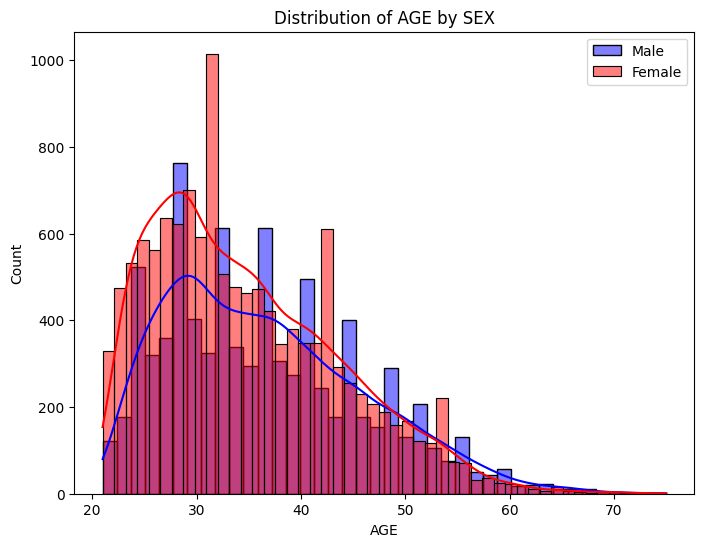

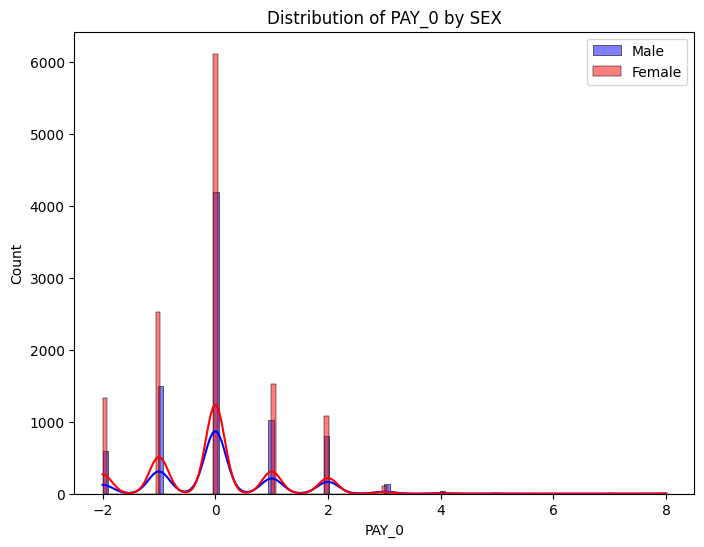

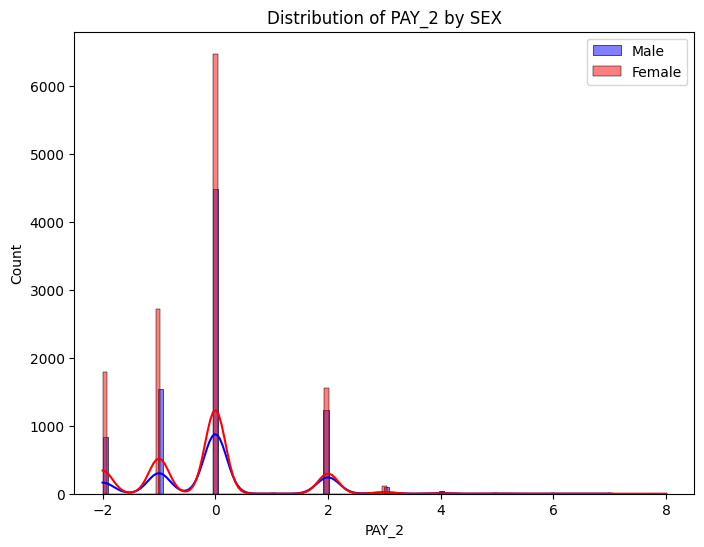

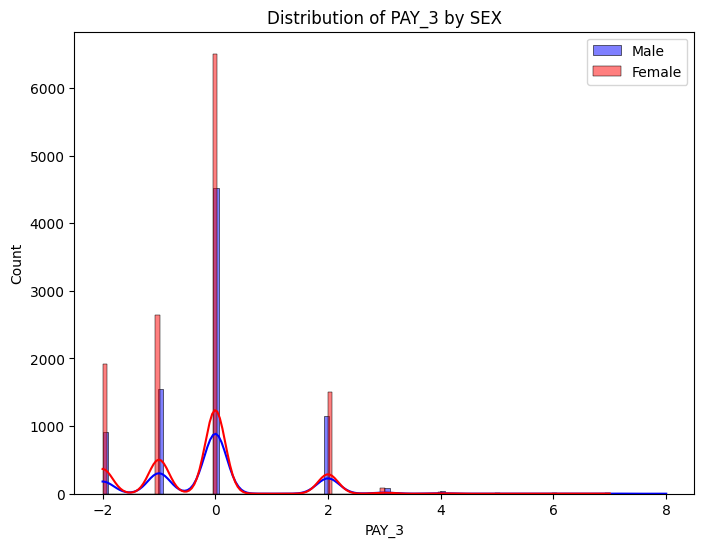

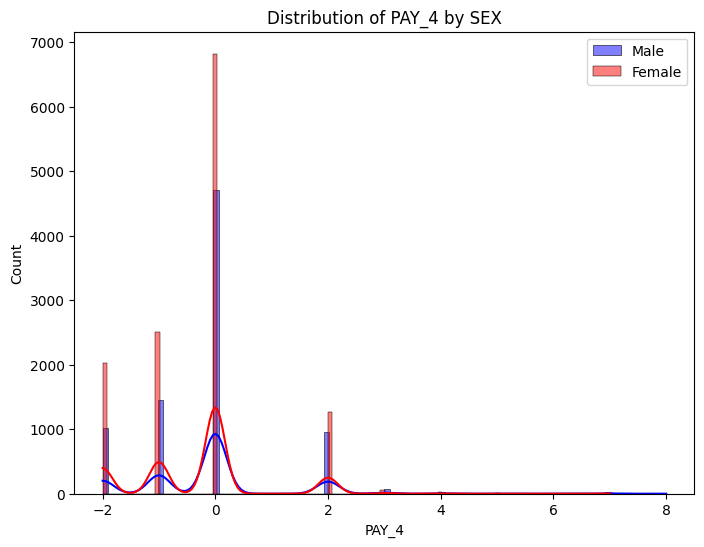

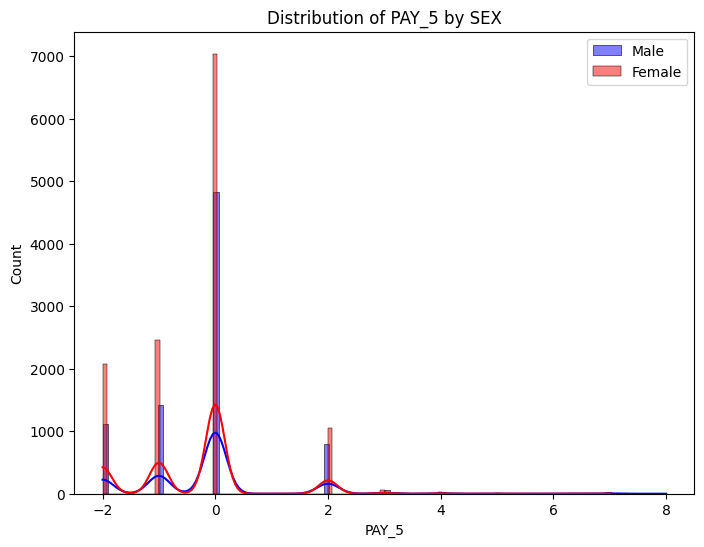

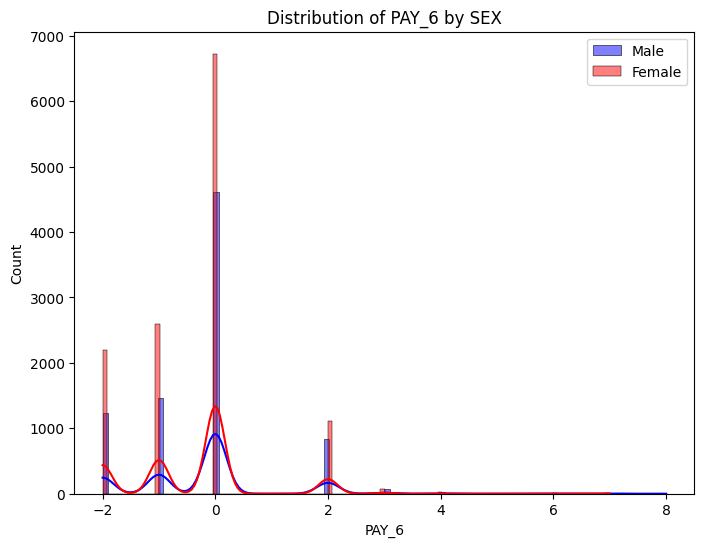

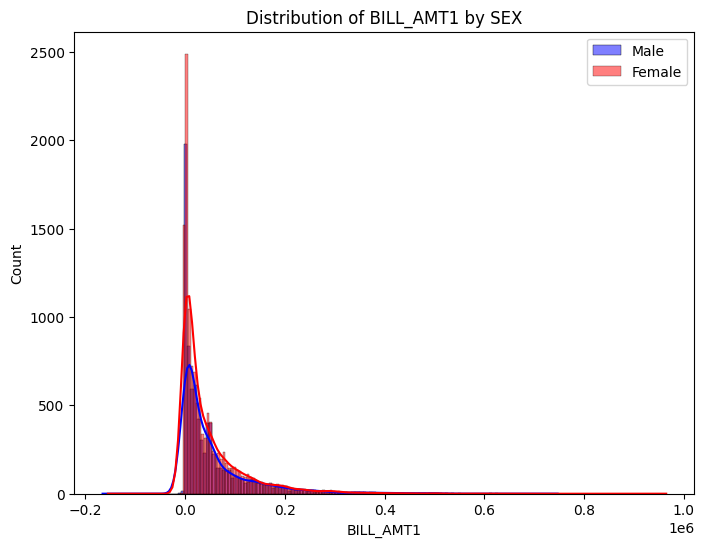

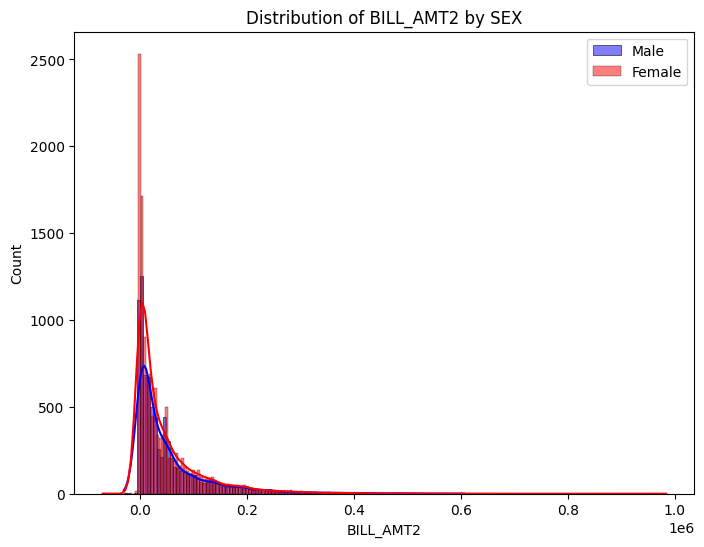

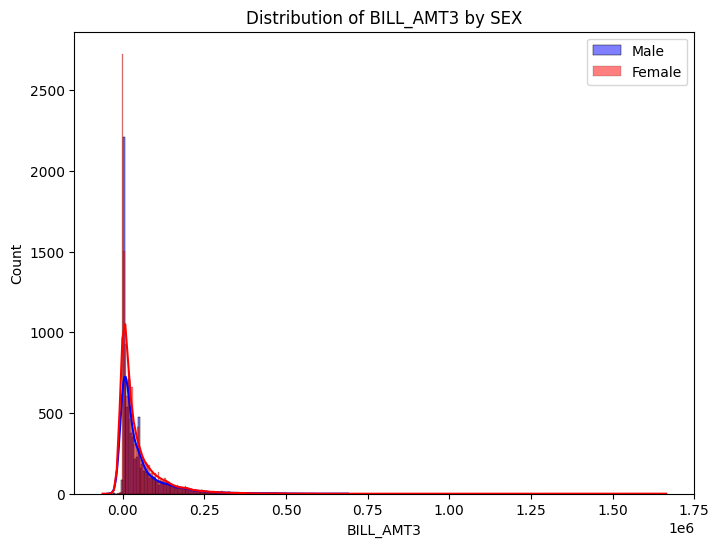

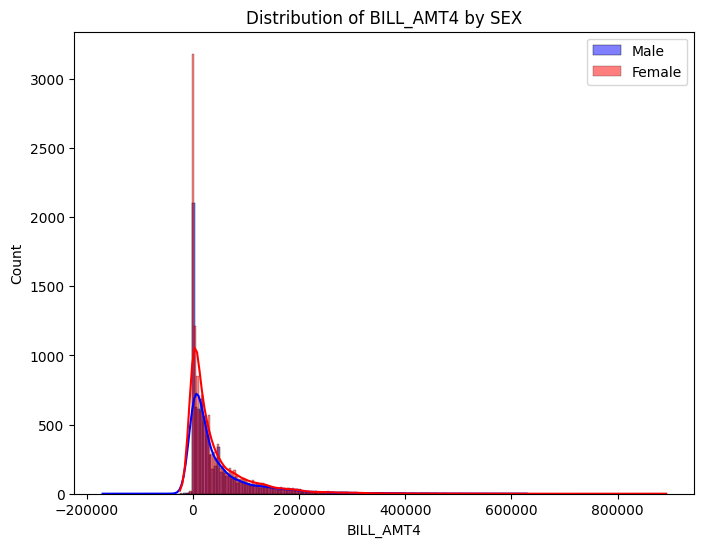

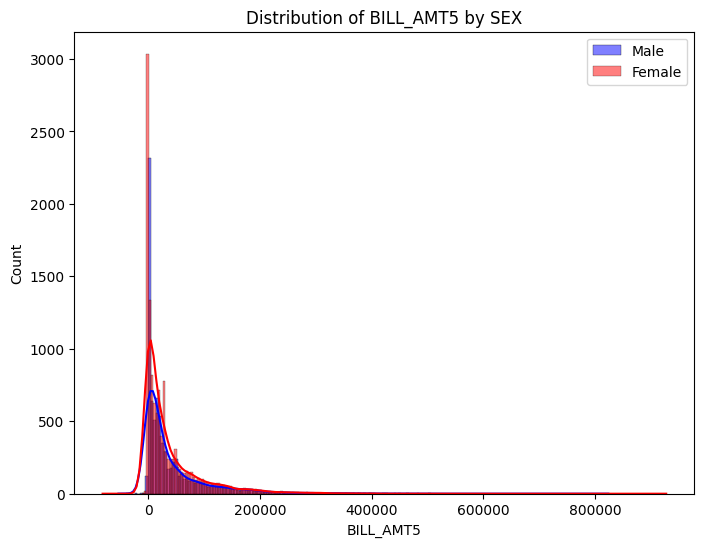

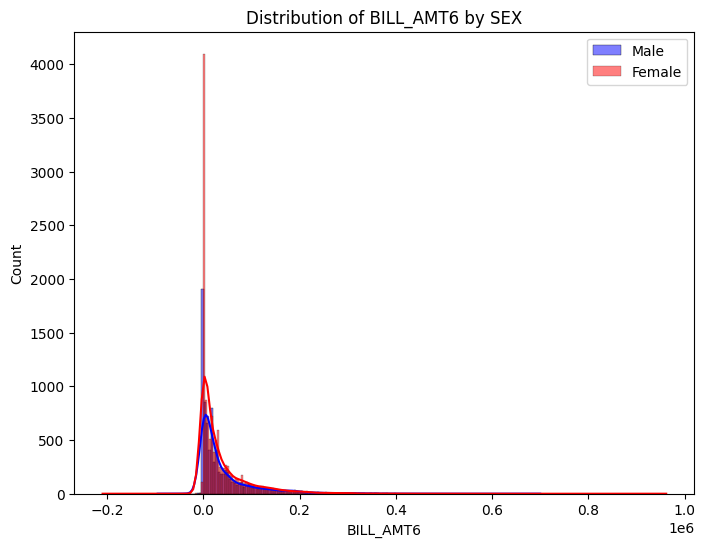

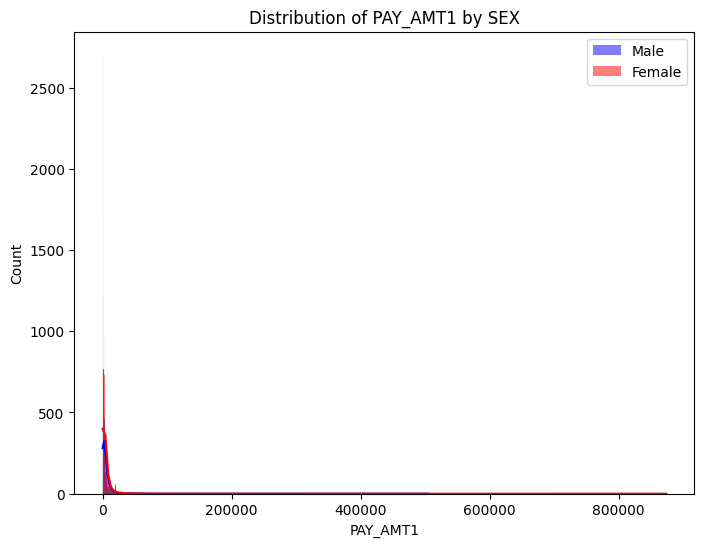

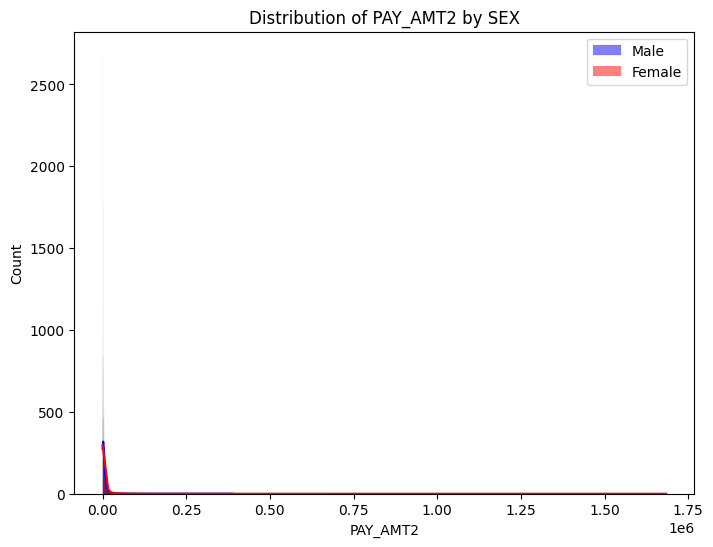

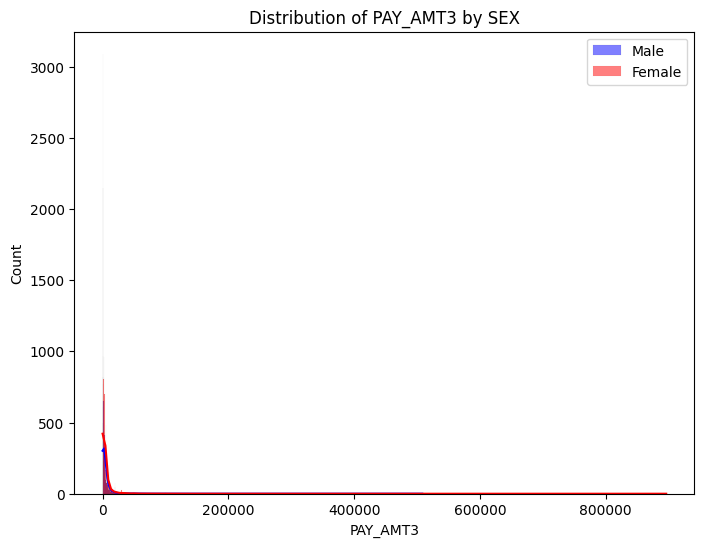

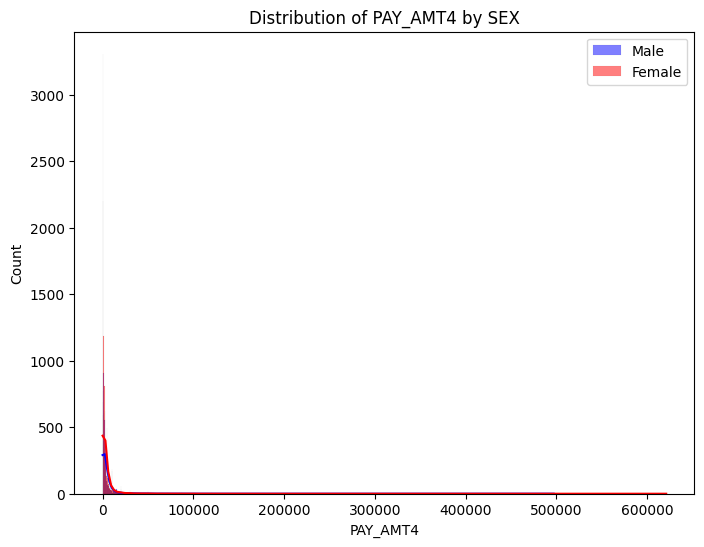

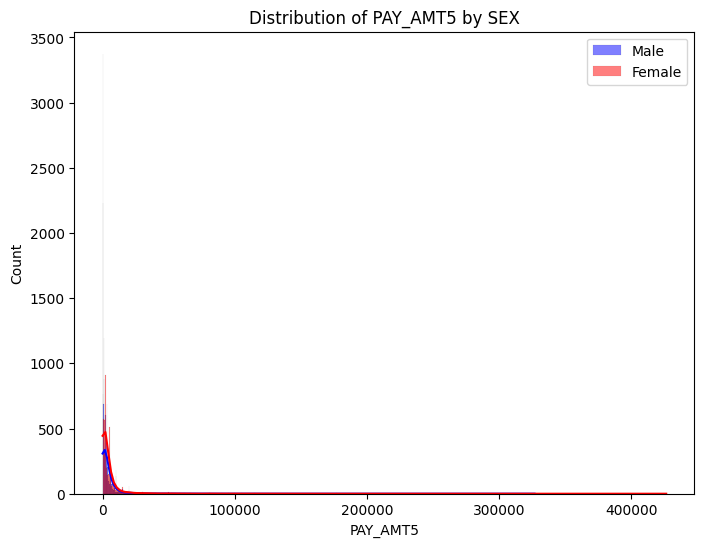

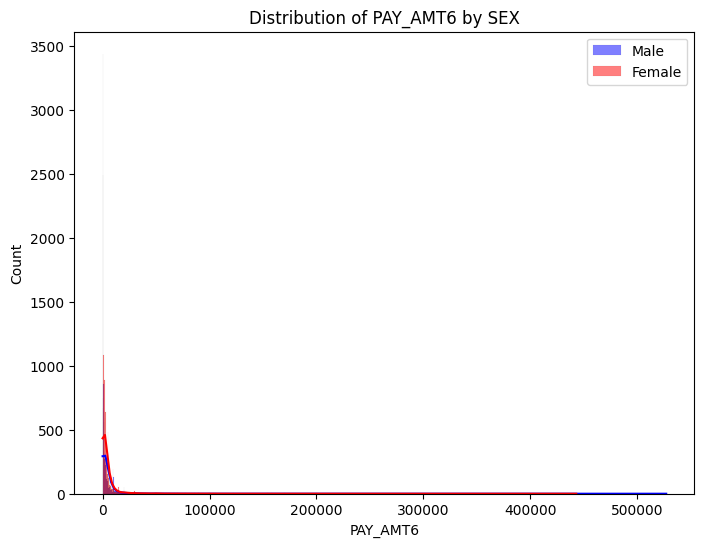

In [15]:
# Separate the dataset by class
male_data = df_train[df_train['SEX'] == 1]
female_data = df_train[df_train['SEX'] == 2]

# Get a list of features excluding SEX and the target variable
features = [col for col in df_train.columns if col not in ['SEX', 'default payment next month']]

# Plot distribution for each feature
for feature in features:
    plt.figure(figsize=(8, 6))
    sns.histplot(male_data[feature], kde=True, color='blue', label='Male')
    sns.histplot(female_data[feature], kde=True, color='red', label='Female')
    plt.title(f'Distribution of {feature} by SEX')
    plt.legend()
    plt.show()

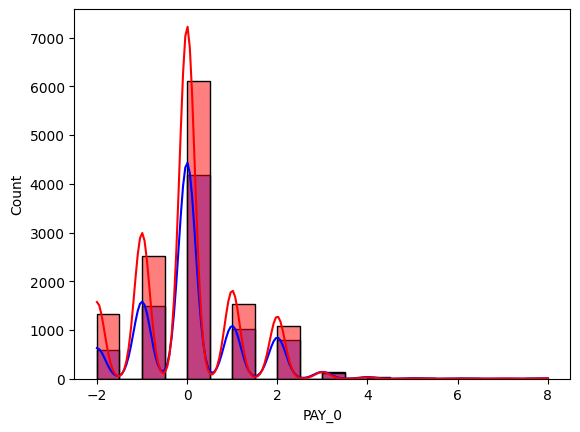

In [22]:
sns.histplot(male_data['PAY_0'], bins=20, kde=True, color='blue', label='Male')
sns.histplot(female_data['PAY_0'], bins=20, kde=True, color='red', label='Female')
plt.show()

In [5]:
# calculating DI manually

def calc_prop(data, group_col, group, output_col, output_val):
    new = data[data[group_col] == group]
    return len(new[new[output_col] == output_val])/len(new)

In [19]:
parity_rate_male = calc_prop(df_train, "SEX", 1, "default payment next month", 0)
parity_rate_female = calc_prop(df_train, "SEX", 2, "default payment next month", 0)
print("parity_rate_male:", parity_rate_male)
print("parity_rate_female:", parity_rate_female)
print("parity rate ration female/male:", parity_rate_female/parity_rate_male)

parity_rate_male: 0.7549540840985983
parity_rate_female: 0.7919515837459719
parity rate ration female/male: 1.049006291146233


In [23]:
# calculating DI using AIF360

privileged_groups = [{'SEX': 1}]
unprivileged_groups = [{'SEX': 2}]

binary_label_dataset_original = BinaryLabelDataset(df=df_train, 
                                        label_names=['default payment next month'], 
                                        protected_attribute_names=['SEX'],
                                        favorable_label=0, # non-default
                                        unfavorable_label=1, # default label
                                        )

di = BinaryLabelDatasetMetric(binary_label_dataset_original,
                              unprivileged_groups = unprivileged_groups,
                              privileged_groups = privileged_groups
                             ).disparate_impact()

print("Disparate Impact:", di)

Disparate Impact: 1.049006291146233


---
# Aplique duas metodologias de pré-processamento mais adequadas à aplicação escolhida.
---

## Reweighing

In [24]:
# Apply Reweighing algorithm
reweighing = Reweighing(unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups)
transformed_data_train = reweighing.fit_transform(binary_label_dataset_original)

In [26]:
reweighing_transformed_di = BinaryLabelDatasetMetric(transformed_data_train,
                              unprivileged_groups = unprivileged_groups,
                              privileged_groups = privileged_groups
                             ).disparate_impact()

print("Disparate Impact:", reweighing_transformed_di)

Disparate Impact: 1.0


***Com reweighing o DI foi para 1.***

---
## Disparate Impact Remover


In [17]:
def apply_dir(rep_lev, bin_label_data):
    di_remover = DisparateImpactRemover(repair_level = rep_lev)
    binary_label_dataset_transformed = di_remover.fit_transform(bin_label_data)
    df_transformed = binary_label_dataset_transformed.convert_to_dataframe()[0] # create the transformed dataframe
    return df_transformed

In [37]:
# Convert DataFrame to BinaryLabelDataset
binary_label_dataset = BinaryLabelDataset(df = df_train,
                                        label_names = ['default payment next month'], 
                                        protected_attribute_names = ['SEX'],
                                        favorable_label = 0, # non-default
                                        unfavorable_label = 1, # default label
                                        )

df_transformed = apply_dir(1, binary_label_dataset)

In [39]:
# calculating DI for the transformed dataset

# convert df_transformed to binary label dataset
binary_label_df_transformed = BinaryLabelDataset(df = df_transformed,
                                        label_names = ['default payment next month'], 
                                        protected_attribute_names = ['SEX'],
                                        favorable_label = 0, # non-default
                                        unfavorable_label = 1, # default label
                                        )

# extract DI metric from transformed dataset
dir_transformed_di = BinaryLabelDatasetMetric(binary_label_df_transformed,
                              unprivileged_groups = unprivileged_groups,
                              privileged_groups = privileged_groups
                             ).disparate_impact()

print("Disparate Impact:", dir_transformed_di)

Disparate Impact: 1.049006291146233


***Não houve mudança ao aplicar o DIR.***

---
# Aplique duas metodologias de processamento mais adequadas à aplicação escolhida.
---

## Adversarial Fairness Classifier

---
# Aplique duas metodologias de pós-processamento mais adequadas à aplicação escolhida.
---

## Calibrated Model to Minimize Equalized Odds

In [41]:
from fairlearn.postprocessing import ThresholdOptimizer

postprocess_est = ThresholdOptimizer(
    estimator = rf_model,
    constraints = "equalized_odds",  # Optimize FPR and FNR simultaneously (wrong)
    # other constraints available: "selection_rate_parity", ’{false,true}_{positive,negative}_rate_parity’
    objective = "balanced_accuracy_score",
    prefit = True,
    predict_method = "predict_proba",
)

postprocess_est

ThresholdOptimizer(constraints='equalized_odds',
                   estimator=RandomForestClassifier(min_samples_leaf=4,
                                                    random_state=42),
                   objective='balanced_accuracy_score',
                   predict_method='predict_proba', prefit=True)

In [53]:
X_train = df_train.drop(['Unnamed: 0', 'ID', 'default payment next month'], axis = 1)
X_val = df_val.drop(['Unnamed: 0', 'ID', 'default payment next month'], axis = 1)
y_train = df_train['default payment next month']
y_val = df_val['default payment next month']
sensitive_features_train = df_train.SEX
sensitive_features_val = df_val.SEX

In [79]:
postprocess_est.fit(X = X_train, y = y_train, sensitive_features = sensitive_features_train, random_seed = 42)

postprocess_pred = postprocess_est.predict(X_val, sensitive_features = sensitive_features_val)

In [80]:
# calculate Equal Opportunity Metric for the calibrated model

male_tpr, female_tpr, equal_opp_metric = equal_opp(df_val,
                                                   postprocess_pred,
                                                   df_val['default payment next month'],
                                                   1,
                                                   2,
                                                   'SEX')

# Compare true positive rates to assess fairness
if equal_opp_metric:
    print("Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).")
else:
    print("Random Forest model: The algorithm does not have Equal Opportunity for both groups (male vs female).")

# Output true positive rates
print("\nTrue Positive Rates:")
print("Male: {:.3f}".format(male_tpr))
print("Female: {:.3f}".format(female_tpr))
print('Equal Opportunity Metric: {:.3f}'.format(equal_opp_metric))

Random Forest model: The algorithm has Equal Opportunity for both groups (male vs female).

True Positive Rates:
Male: 0.474
Female: 0.434
Equal Opportunity Metric: 0.040
